In [1]:
import pandas as pd
from datetime import datetime
import os
import math
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

In [2]:
def interquartileRule(data):
    # Calculate the first quartile (Q1)
    Q1 = np.percentile(data, 25)

    # Calculate the third quartile (Q3)
    Q3 = np.percentile(data, 75)

    # Calculate the interquartile range (IQR)
    IQR = Q3 - Q1

    # Define the upper and lower bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    return lower_bound, upper_bound

In [3]:
def comparativeBoxplot(testPreDf, testPostDf, validationDf):
    # Create a figure and axis
    fig, ax = plt.subplots()

    plt.title("Comparative boxplot of the reconstruction MSE error")
    # Plot the first distribution as a boxplot
    bp1 = ax.boxplot(testPreDf.errors, positions=[1], patch_artist=True, boxprops=dict(facecolor='blue'))

    # Plot the second distribution as a boxplot
    bp2 = ax.boxplot(testPostDf.errors, positions=[2], patch_artist=True, boxprops=dict(facecolor='red'))

    # Plot the third distribution as a boxplot
    bp3 = ax.boxplot(validationDf.errors, positions=[3], patch_artist=True, boxprops=dict(facecolor='green'))

    # Add a legend
    ax.legend([bp1["boxes"][0], bp2["boxes"][0], bp3["boxes"][0]], ['preIntervention', 'postIntervention', "validation"])

    plt.ylim(0,0.5)
    # Show the plot
    plt.show()

In [4]:
path = "./INSIST_small/INSISTevaluator_small/"
testPost = []
testPre = []
validation = []
for file in os.listdir("./INSIST_small/INSISTevaluator_small/"):
    df = pd.read_csv(path + file)
    if "Pre" in file:
        testPre.append(df)
    elif "Post" in file:
        testPost.append(df)
    elif "validation" in file:
        validation.append(df)

testPostDf = pd.concat(testPost).drop(columns=["Unnamed: 0"])
testPreDf = pd.concat(testPre).drop(columns=["Unnamed: 0"])
validationDf = pd.concat(validation).drop(columns=["Unnamed: 0"])

In [5]:
testPostDf.shape, testPreDf.shape, validationDf.shape

((163562, 2), (248501, 2), (143096, 2))

In [6]:
testPostDf.sort_values("dates", inplace=True)
testPostDf.reset_index(drop=True, inplace=True)

testPreDf.sort_values("dates", inplace=True)
testPreDf.reset_index(drop=True, inplace=True)

validationDf.sort_values("dates", inplace=True)
validationDf.reset_index(drop=True, inplace=True)

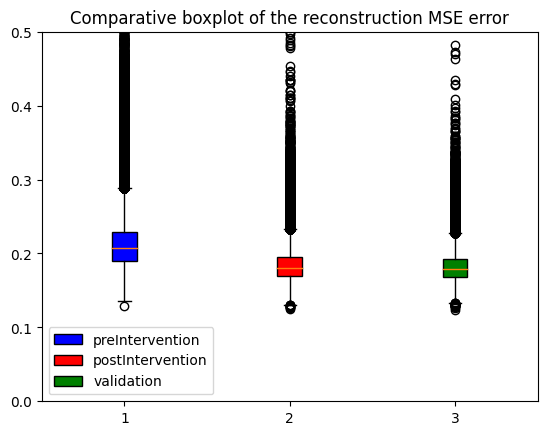

In [7]:
comparativeBoxplot(testPreDf, testPostDf, validationDf)

In [8]:
def rollingOutliers(x):
    lower_bound, upper_bound = interquartileRule(x)
    if (x.iloc[-1] >lower_bound)&(x.iloc[-1]<upper_bound):
        return True
    else:
        return False

In [9]:
validationDf["flag"] = validationDf["errors"].rolling(10000).apply(rollingOutliers)
validationDf["flag"].fillna(1.0, inplace=True)
print(validationDf["flag"].value_counts())
validationDf = validationDf[validationDf["flag"]>0]
validationDf.reset_index(drop=True, inplace=True)

1.0    138950
0.0      4146
Name: flag, dtype: int64


In [10]:
testPreDf["flag"] = testPreDf["errors"].rolling(10000).apply(rollingOutliers)
testPreDf["flag"].fillna(1.0, inplace=True)
print(testPreDf["flag"].value_counts())
testPreDf = testPreDf[testPreDf["flag"]>0]
testPreDf.reset_index(drop=True, inplace=True)

1.0    239366
0.0      9135
Name: flag, dtype: int64


In [11]:
testPostDf["flag"] = testPostDf["errors"].rolling(10000).apply(rollingOutliers)
testPostDf["flag"].fillna(1.0, inplace=True)
print(testPreDf["flag"].value_counts())
testPostDf = testPostDf[testPostDf["flag"]>0]
testPostDf.reset_index(drop=True, inplace=True)

1.0    239366
Name: flag, dtype: int64


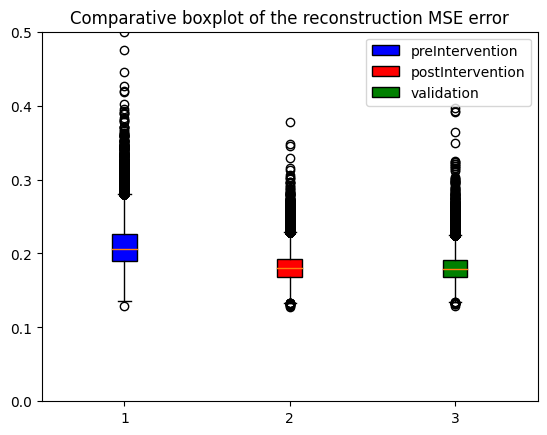

In [ ]:
comparativeBoxplot(testPreDf, testPostDf, validationDf)

### Thresholds definition

In [45]:
validationDf["movingError"] = validationDf["errors"].rolling(200).mean()

In [46]:
valMean = validationDf["movingError"].mean()
valStd = validationDf["movingError"].std()

In [12]:
testPreDf["anomaly"] = True
testPostDf["anomaly"] = False

testDF = pd.concat([testPreDf, testPostDf]).reset_index(drop=True)
testDF

,dates,errors,flag,anomaly
0,2019-04-30 22:00:32.910,0.202343,1.0,True
1,2019-04-30 22:00:33.910,0.171596,1.0,True
2,2019-04-30 22:00:34.910,0.198365,1.0,True
3,2019-04-30 22:00:35.910,0.222319,1.0,True
4,2019-04-30 22:00:36.910,0.205949,1.0,True
...,...,...,...,...
396823,2019-06-04 19:30:15.564,0.189366,1.0,False
396824,2019-06-04 19:30:31.564,0.189688,1.0,False
396825,2019-06-04 19:30:32.564,0.180373,1.0,False
396826,2019-06-04 19:30:33.564,0.206018,1.0,False


In [48]:
testDF["movingError"] = testDF["errors"].rolling(200).mean()

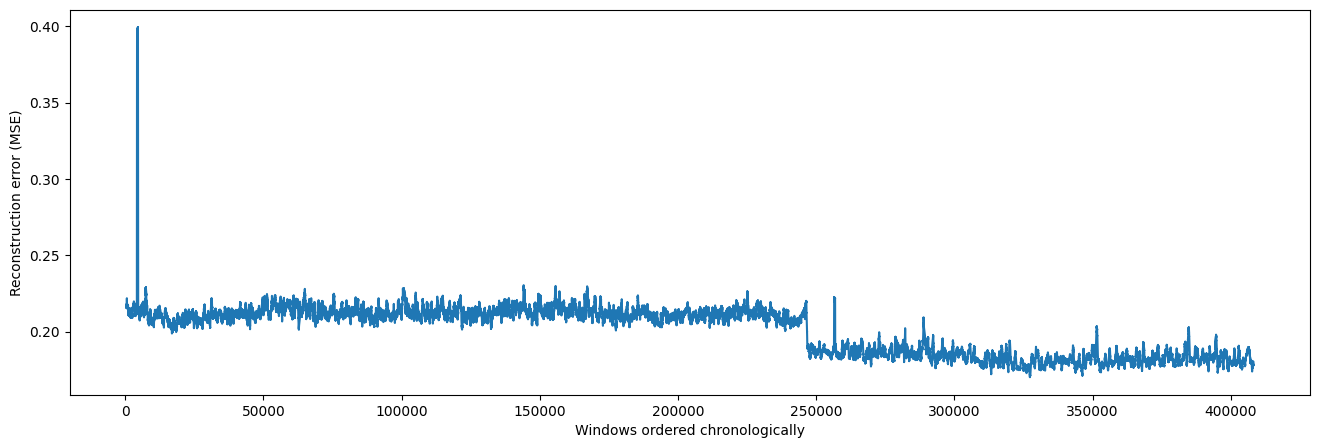

In [79]:
plt.figure(figsize=(16, 5))
plt.xlabel("Windows ordered chronologically")
plt.ylabel("Reconstruction error (MSE)")
#plt.axvline(248501, color='r')
plt.plot(testDF["movingError"])

In [49]:
def statisticsProvider(threshold):
    testDF["prediction"] = testDF["movingError"].apply(lambda x: x>threshold)
    y_true, y_pred = testDF["anomaly"], testDF["prediction"]
    acc = accuracy_score(y_true, y_pred)
    conf_mat = confusion_matrix(testDF["anomaly"], testDF["prediction"], labels=[True, False])
    tp, fn, fp, tn = conf_mat.ravel()

    scores =precision_recall_fscore_support(y_true, y_pred)

    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    print(f"Precision False: {scores[0][0]}, Precision True: {scores[0][1]}")
    print(f"recall False: {scores[1][0]}, recall True: {scores[1][1]}")
    print(f"fscore False: {scores[2][0]}, fscore True: {scores[2][1]}")
    print(f"accuracy: {acc}")
    print("Sensitivity:", sensitivity)
    print("Specificity:", specificity)

    
    ax= plt.subplot()
    sns.heatmap(conf_mat, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['True', 'False']); ax.yaxis.set_ticklabels(['True', 'False'])

    return acc, sensitivity, specificity

No moving window

Threshold 1

In [50]:
threshold1 = valMean + 3.5*valStd
threshold1

0.195434595721569

Precision False: 0.9986257414604214, Precision True: 0.9948872618354272
recall False: 0.9921949422717862, recall True: 0.9991017939055672
fscore False: 0.9953999554012296, fscore True: 0.9969900739141128
accuracy: 0.9963611438708962
Sensitivity: 0.9991017939055672
Specificity: 0.9921949422717862


(0.9963611438708962, 0.9991017939055672, 0.9921949422717862)

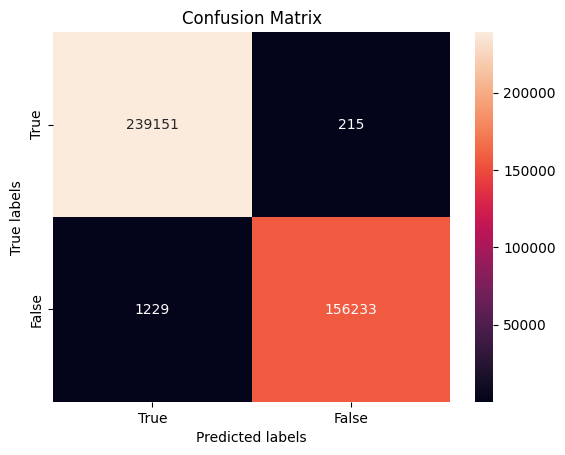

In [51]:
statisticsProvider(threshold1)

Threshold 2

In [22]:
threshold2 = valMean + 2.5*valStd
threshold2

0.19653657793440563

Precision False: 0.9901379662749106, Precision True: 0.9717734896932574
recall False: 0.9561157335734684, recall True: 0.9937362320839604
fscore False: 0.9728294805940552, fscore True: 0.9826321542827916
accuracy: 0.9788095774151551
Sensitivity: 0.9937362320839604
Specificity: 0.9561157335734684


(0.9788095774151551, 0.9937362320839604, 0.9561157335734684)

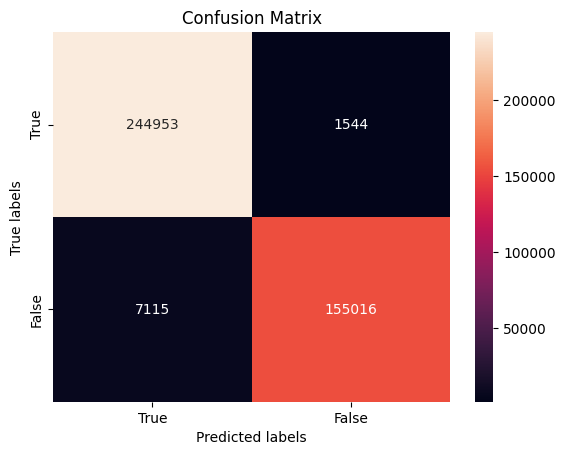

In [23]:
statisticsProvider(threshold2)

Threshold 3

In [24]:
threshold3 = valMean + 2*valStd
threshold3

0.19357511930301877

Precision False: 0.9983016191231027, Precision True: 0.9526355494516123
recall False: 0.92448698891637, recall True: 0.9989655046511722
fscore False: 0.9599774556959594, fscore True: 0.9752506029917898
accuracy: 0.969414724394804
Sensitivity: 0.9989655046511722
Specificity: 0.92448698891637


(0.969414724394804, 0.9989655046511722, 0.92448698891637)

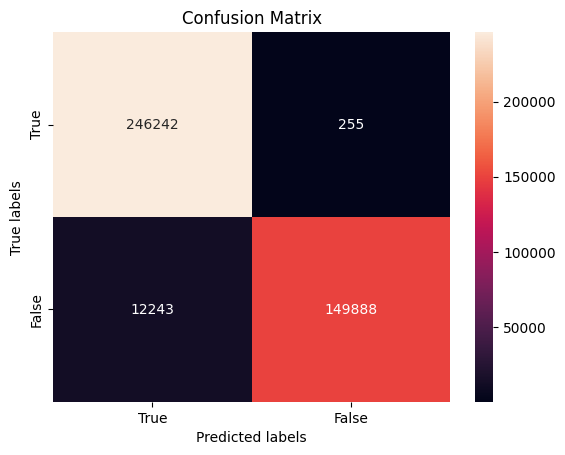

In [25]:
statisticsProvider(threshold3)

Threshold 4

In [148]:
data = validationDf["errors"].dropna()
# Calculate the first quartile (Q1)
Q1 = np.percentile(data, 25)

# Calculate the third quartile (Q3)
Q3 = np.percentile(data, 75)

# Calculate the interquartile range (IQR)
IQR = Q3 - Q1

# Define the upper and lower bounds
#lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [149]:
upper_bound

0.22448644060633804

Precision False: 0.3976551000813216, Precision True: 1.0
recall False: 1.0, recall True: 0.004746815573238676
fscore False: 0.5690318019920427, fscore True: 0.009448779532643701
accuracy: 0.3993805937912864
Sensitivity: 0.004746815573238676
Specificity: 1.0


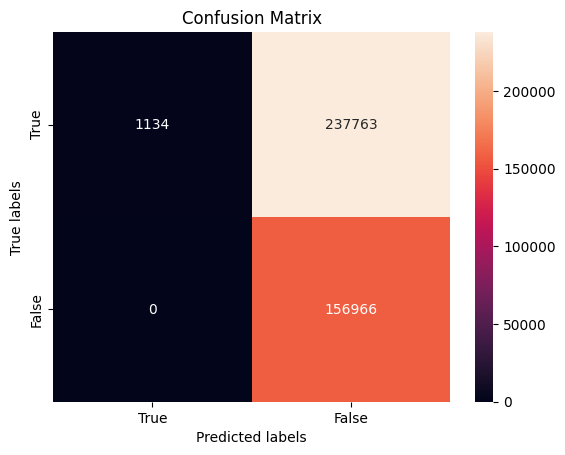

In [150]:
statisticsProvider(upper_bound)

Sensitivity and specificity

In [123]:
#testDF["movingError"] = testDF["errors"].rolling(500).mean()

In [151]:
threshold3 = valMean + 3*valStd
threshold3

0.19336916277712868

In [158]:
testDF["prediction"] = testDF["movingError"].apply(lambda x: x>threshold3)
testDF["prediction"].value_counts()

True     238939
False    156924
Name: prediction, dtype: int64

In [13]:
def statisticsCalculator(df):
    y_true, y_pred = df["anomaly"], df["prediction"]
    acc = accuracy_score(y_true, y_pred)
    conf_mat = confusion_matrix(y_true, y_pred, labels=[True, False])
    tp, fn, fp, tn = conf_mat.ravel()

    #scores = precision_recall_fscore_support(y_true, y_pred)
    if (tp + fn) > 0:
        sensitivity = tp / (tp + fn)
    else:
        sensitivity = np.nan

    if (tn + fp) > 0:
        specificity = tn / (tn + fp)
    else:
        specificity = np.nan

    return acc, sensitivity, specificity

In [160]:
windowSize = 100
accs = []
sensitivities = []
specificities = []
for index, row in tqdm(testDF.iterrows()):
    if index < windowSize-1:
        accs.append(np.nan)
        sensitivities.append(np.nan)
        specificities.append(np.nan)
        continue
    slice = testDF[index+1-windowSize:index+1]
    acc, sensitivity, specificity = statisticsCalculator(slice)
    accs.append(acc)
    sensitivities.append(sensitivity)
    specificities.append(specificity)

testDF["accuracy"] =  accs
testDF["sensitivity"] = sensitivities
testDF["specificity"] = specificities

testDF

395863it [03:20, 1978.01it/s]


,dates,errors,anomaly,prediction,movingError,accuracy,sensitivity,specificity
0,2019-04-30 22:00:32.910,0.202343,True,False,NaN,NaN,NaN,NaN
1,2019-04-30 22:00:33.910,0.171596,True,False,NaN,NaN,NaN,NaN
2,2019-04-30 22:00:34.910,0.198365,True,False,NaN,NaN,NaN,NaN
3,2019-04-30 22:00:35.910,0.222319,True,False,NaN,NaN,NaN,NaN
4,2019-04-30 22:00:36.910,0.205949,True,False,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
395858,2019-06-04 19:30:15.564,0.189366,False,False,0.179579,1.0,NaN,1.0
395859,2019-06-04 19:30:31.564,0.189688,False,False,0.179596,1.0,NaN,1.0
395860,2019-06-04 19:30:32.564,0.180373,False,False,0.179633,1.0,NaN,1.0
395861,2019-06-04 19:30:33.564,0.206018,False,False,0.179669,1.0,NaN,1.0


In [161]:
print(f'Accuracy: {testDF["accuracy"].mean()}')
print(f'sensitivity: {testDF["sensitivity"].mean()}')
print(f'specificity: {testDF["specificity"].mean()}')

Accuracy: 0.9974972458333754
sensitivity: 0.9981184359786853
specificity: 0.9962380388109527


### Analysis threshold vs agg

In [14]:
def statisticsCalculator(df):
    y_true, y_pred = df["anomaly"], df["prediction"]
    acc = accuracy_score(y_true, y_pred)
    conf_mat = confusion_matrix(y_true, y_pred, labels=[True, False])
    tp, fn, fp, tn = conf_mat.ravel()

    #scores = precision_recall_fscore_support(y_true, y_pred)
    if (tp + fn) > 0:
        sensitivity = tp / (tp + fn)
    else:
        sensitivity = np.nan

    if (tn + fp) > 0:
        specificity = tn / (tn + fp)
    else:
        specificity = np.nan

    return acc, sensitivity, specificity

Aggregation by # vehicles

In [29]:
sizeMovingAverage = [10, 25, 50, 100, 200, 400, 500, 1000]
thresholdsOptions = ["2.5std", "3std", "3.5std"]

In [34]:
results = {"sizeMovingAverage": [],
            "threshold": [],
            "accuracy": [],
            "sensitivity": [],
            "specificity": []}

for rollingOption in sizeMovingAverage:
    validationDf["movingError"] = validationDf["errors"].rolling(rollingOption).mean()
    valMean = validationDf["movingError"].mean()
    valStd = validationDf["movingError"].std()
    testDF["movingError"] = testDF["errors"].rolling(rollingOption).mean()

    rollingThresholds = {"2.5std": valMean+(2.5*valStd),
                        "3std": valMean+(3*valStd),
                        "3.5std": valMean+(3.5*valStd),}

    for thresholdOpt in thresholdsOptions:
        threshold = rollingThresholds[thresholdOpt]
        testDF["prediction"] = testDF["movingError"].apply(lambda x: x>threshold)
        acc, sensitivity, specificity = statisticsCalculator(testDF)
        results["sizeMovingAverage"].append(rollingOption)
        results["threshold"].append(thresholdOpt)
        results["accuracy"].append(acc)
        results["sensitivity"].append(sensitivity)
        results["specificity"].append(specificity)

resultsVehiclesDf = pd.DataFrame(results)

In [35]:
resultsVehiclesDf

,sizeMovingAverage,threshold,accuracy,sensitivity,specificity
0,10,2.5std,0.864311,0.795389,0.969085
1,10,3std,0.807350,0.689676,0.986232
2,10,3.5std,0.740553,0.573883,0.993916
3,25,2.5std,0.952214,0.943451,0.965535
4,25,3std,0.920202,0.878295,0.983907
5,25,3.5std,0.868273,0.786728,0.992233
6,50,2.5std,0.979543,0.990341,0.963128
7,50,3std,0.974271,0.968646,0.982821
8,50,3.5std,0.948618,0.920248,0.991744
9,100,2.5std,0.984434,0.999269,0.961883


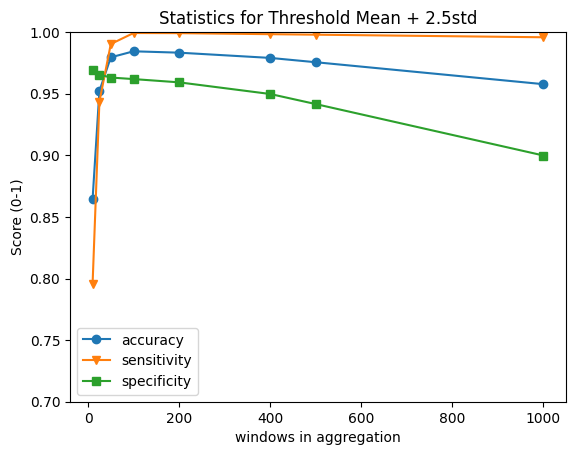

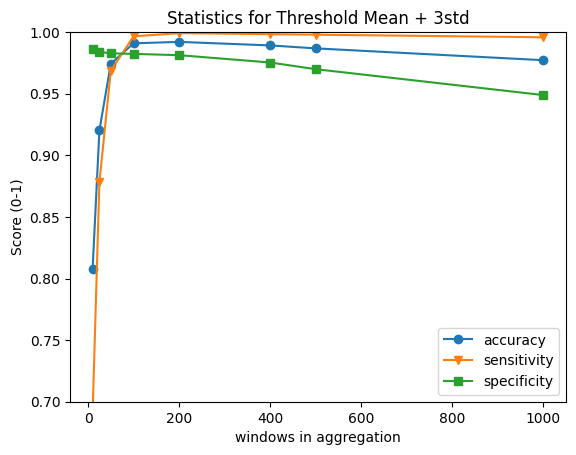

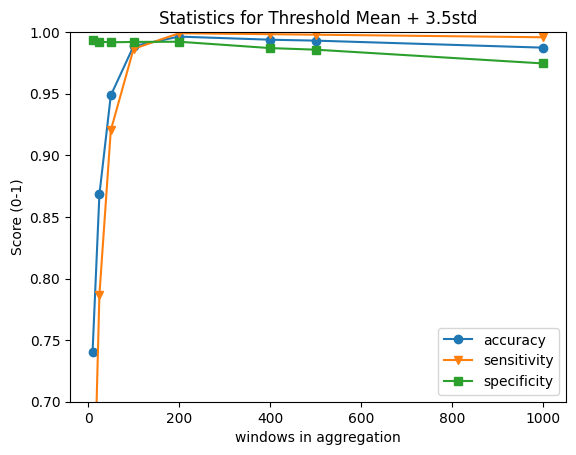

In [36]:
for thresholdOpt in thresholdsOptions:
    pltDf = resultsVehiclesDf[resultsVehiclesDf["threshold"]==thresholdOpt]
    x_categories = pltDf["sizeMovingAverage"]

    # Create the plot
    plt.plot(x_categories, pltDf["accuracy"], marker='o', label='accuracy')
    plt.plot(x_categories, pltDf["sensitivity"], marker='v', label='sensitivity')
    plt.plot(x_categories, pltDf["specificity"], marker='s', label='specificity')

    # Add labels and title
    plt.ylim(0.7, 1)
    plt.xlabel('windows in aggregation')
    plt.ylabel('Score (0-1)')
    plt.title(f'Statistics for Threshold Mean + {thresholdOpt}')

    # Add legend
    plt.legend()

    # Display the plot
    plt.show()
    

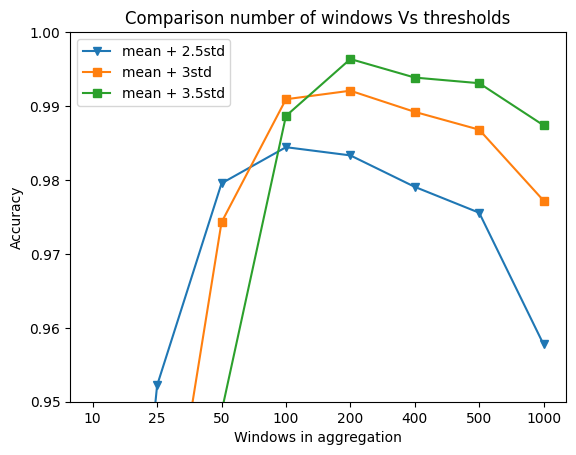

In [53]:
x_categories = resultsVehiclesDf["sizeMovingAverage"].unique()
x_categories = [str(x) for x in x_categories]
# Create the plot
#plt.plot(x_categories, resultsDf[resultsDf["threshold"]=="2std"]["accuracy"], marker='o', label='mean + 2std')
plt.plot(x_categories, resultsVehiclesDf[resultsVehiclesDf["threshold"]=="2.5std"]["accuracy"], marker='v', label='mean + 2.5std')
plt.plot(x_categories, resultsVehiclesDf[resultsVehiclesDf["threshold"]=="3std"]["accuracy"], marker='s', label='mean + 3std')
plt.plot(x_categories, resultsVehiclesDf[resultsVehiclesDf["threshold"]=="3.5std"]["accuracy"], marker='s', label='mean + 3.5std')

# Add labels and title
plt.ylim(0.95, 1)
plt.xlabel('Windows in aggregation')
plt.ylabel('Accuracy')
plt.title(f'Comparison number of windows Vs thresholds')

# Add legend
plt.legend()

# Display the plot
plt.show()

### Aggregation by time

In [38]:
results = {"sizeMovingAverage": [],
            "threshold": [],
            "accuracy": [],
            "sensitivity": [],
            "specificity": []}

sizeMovingAverage = [30, 60, 300, 1800, 3600, 6400]

for rollingOption in tqdm(sizeMovingAverage):
    testDFCopy = testDF.copy(deep=True)
    thresholdsOptions = ["2std", "2.5std", "3std", "3.5std"]
    print(f"Start calculation statistics on validation set")
    validationDf["timestamp"] = pd.to_datetime(validationDf['dates'])
    movingError = []
    for index, row in validationDf.iterrows():
        startDate = row["timestamp"] + pd.Timedelta(-rollingOption, "s")
        endDate = row["timestamp"] 
        subErrors = validationDf[(validationDf["timestamp"]>=startDate) & (validationDf["timestamp"]<=endDate)]["errors"]
        movingError.append(subErrors.mean())
    validationDf["movingError"] = movingError
    valMean = validationDf["movingError"].mean()
    valStd = validationDf["movingError"].std()

    print(f"Start calculating the moving error on Test set")
    testDFCopy["timestamp"] = pd.to_datetime(testDFCopy['dates'])
    movingError = []
    for index, row in testDFCopy.iterrows():
        startDate = row["timestamp"] + pd.Timedelta(-rollingOption, "s")
        endDate = row["timestamp"] 
        subErrors = testDFCopy[(testDFCopy["timestamp"]>=startDate) & (testDFCopy["timestamp"]<=endDate)]["errors"]
        if len(subErrors)>=10:
            movingError.append(subErrors.mean())
        else:
            movingError.append(np.nan)
    testDFCopy["movingError"] = movingError
    testDFCopy.dropna(inplace=True)

    rollingThresholds = {"2std": valMean+(2*valStd),
                        "2.5std": valMean+(2.5*valStd),
                        "3std": valMean+(3*valStd),
                        "3.5std": valMean+(3.5*valStd),}

    print(f"Comparing moving error with different thresholds")
    for thresholdOpt in thresholdsOptions:
        threshold = rollingThresholds[thresholdOpt]
        testDFCopy["prediction"] = testDFCopy["movingError"].apply(lambda x: x>threshold)
        acc, sensitivity, specificity = statisticsCalculator(testDFCopy)
        results["sizeMovingAverage"].append(rollingOption)
        results["threshold"].append(thresholdOpt)
        results["accuracy"].append(acc)
        results["sensitivity"].append(sensitivity)
        results["specificity"].append(specificity)

resultsTimeDf = pd.DataFrame(results)

  0%|          | 0/6 [00:00<?, ?it/s]

Start calculation statistics on validation set
Start calculating the moving error on Test set
Comparing moving error with different thresholds


 17%|█▋        | 1/6 [18:19<1:31:36, 1099.39s/it]

Start calculation statistics on validation set
Start calculating the moving error on Test set
Comparing moving error with different thresholds


 33%|███▎      | 2/6 [35:57<1:11:41, 1075.38s/it]

Start calculation statistics on validation set
Start calculating the moving error on Test set
Comparing moving error with different thresholds


 50%|█████     | 3/6 [51:28<50:27, 1009.05s/it]  

Start calculation statistics on validation set
Start calculating the moving error on Test set
Comparing moving error with different thresholds


 67%|██████▋   | 4/6 [1:08:01<33:26, 1003.04s/it]

Start calculation statistics on validation set
Start calculating the moving error on Test set
Comparing moving error with different thresholds


 83%|████████▎ | 5/6 [1:26:45<17:26, 1046.48s/it]

Start calculation statistics on validation set
Start calculating the moving error on Test set
Comparing moving error with different thresholds


100%|██████████| 6/6 [1:44:41<00:00, 1046.96s/it]


In [39]:
resultsTimeDf

,sizeMovingAverage,threshold,accuracy,sensitivity,specificity
0,30,2std,0.963540,0.999478,0.912428
1,30,2.5std,0.977669,0.998649,0.947830
2,30,3std,0.983946,0.996330,0.966334
3,30,3.5std,0.984814,0.990322,0.976980
4,60,2std,0.962413,0.999837,0.908072
5,60,2.5std,0.978276,0.999446,0.947537
6,60,3std,0.985401,0.998959,0.965716
7,60,3.5std,0.988204,0.997315,0.974975
8,300,2std,0.940118,0.999971,0.849628
9,300,2.5std,0.970827,0.999962,0.926779


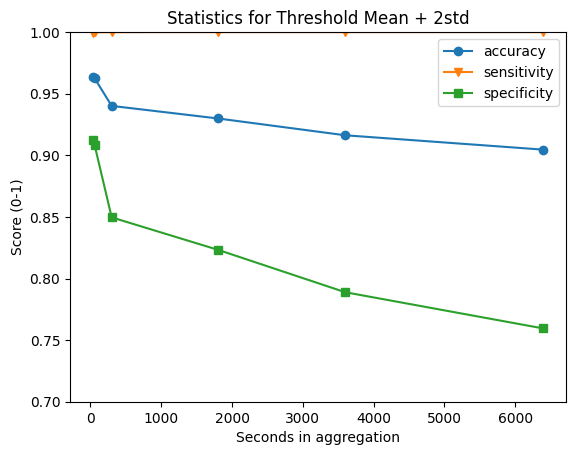

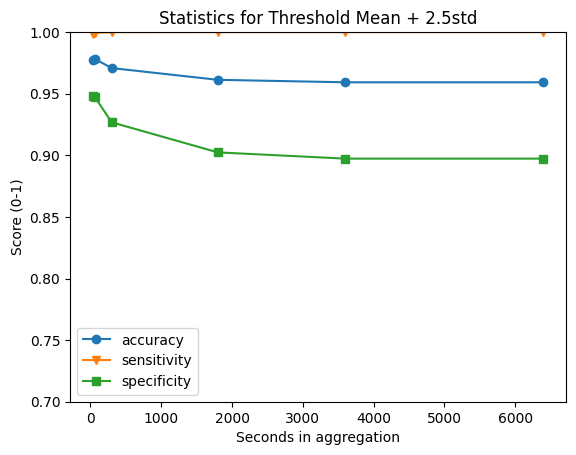

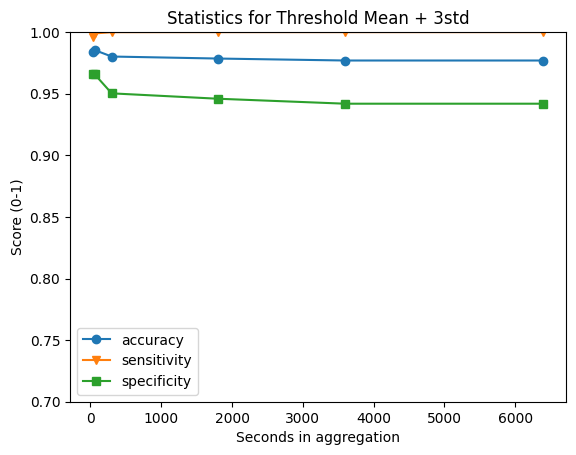

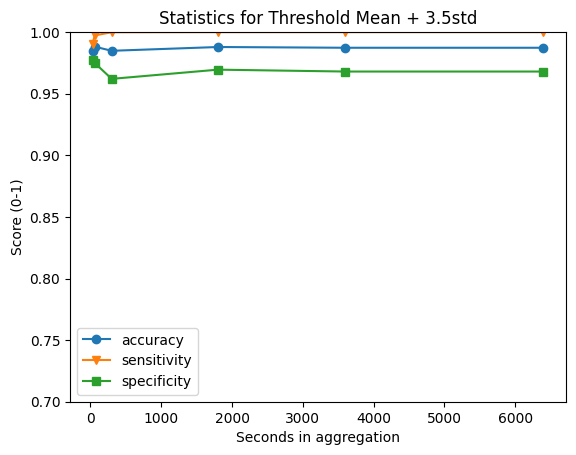

In [25]:
for thresholdOpt in thresholdsOptions:
    pltDf = resultsTimeDf[resultsTimeDf["threshold"]==thresholdOpt]
    x_categories = pltDf["sizeMovingAverage"]

    # Create the plot
    plt.plot(x_categories, pltDf["accuracy"], marker='o', label='accuracy')
    plt.plot(x_categories, pltDf["sensitivity"], marker='v', label='sensitivity')
    plt.plot(x_categories, pltDf["specificity"], marker='s', label='specificity')

    # Add labels and title
    plt.ylim(0.7, 1)
    plt.xlabel('Seconds in aggregation')
    plt.ylabel('Score (0-1)')
    plt.title(f'Statistics for Threshold Mean + {thresholdOpt}')

    # Add legend
    plt.legend()

    # Display the plot
    plt.show()
    

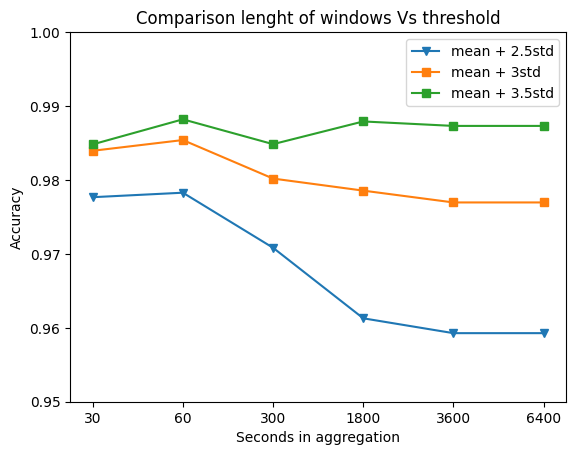

In [52]:
x_categories = resultsTimeDf["sizeMovingAverage"].unique()
x_categories = [str(x) for x in x_categories]
# Create the plot
#plt.plot(x_categories, resultsDf[resultsDf["threshold"]=="2std"]["accuracy"], marker='o', label='mean + 2std')
plt.plot(x_categories, resultsTimeDf[resultsTimeDf["threshold"]=="2.5std"]["accuracy"], marker='v', label='mean + 2.5std')
plt.plot(x_categories, resultsTimeDf[resultsTimeDf["threshold"]=="3std"]["accuracy"], marker='s', label='mean + 3std')
plt.plot(x_categories, resultsTimeDf[resultsTimeDf["threshold"]=="3.5std"]["accuracy"], marker='s', label='mean + 3.5std')

# Add labels and title
plt.ylim(0.95, 1)
plt.xlabel('Seconds in aggregation')
plt.ylabel('Accuracy')
plt.title(f'Comparison lenght of windows Vs threshold')

# Add legend
plt.legend()

# Display the plot
plt.show()